<div style="border-width:5px; border-style:double; border-radius:10px; border-top-color:black; border-bottom-color:darkblue; padding:15px; box-shadow:3px 3px 10px rgba(0,0,0,0.3);background:linear-gradient(to right, darkblue, orange); border-right-color:darkblue; border-left-color:darkblue"> 
<h1 style="text-align:center; font-weight:bold; font-size: 45px; color:white"> Titanic Survival Analysis</h1>
</div>

<br></br>

## Project Description

<div style="text-align: justify;font-size:18px;">In the 1997 film Titanic, one of the most emotionally charged scenes depicts crew members shouting "women and children first" as lifeboats are loaded. This dramatization was supposed to be rooted in historical accounts of the disaster. This cultural portrayal will be investigated to align with survival patterns observed in the actual data. This project will utilize the Titanic Survival Dataset to develop the best model that predicts whether a passenger survived the sinking of the Titanic, based on the attributes of each passenger. The analysis begins with Logistic Regression and then proceeds to Random Forest, contrasting their predictions in a manner similar to how the film contrasts Jack’s struggle for survival with the privilege of wealthier passengers. One model delivers a clear statistical story, while the other paints a richer picture of how social status and fortune determined fate on the Titanic.</div>

<br></br>

#### Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Feature Description


| Variable   |	Definition   |
 |:------|:--------------------------------|
 |survived | survived? 0 = No, 1 = yes  |
 |pclass | Ticket class (int)  |
 |sex	 |sex |
 |age	 | age in years  |
 |sibsp  |	# of siblings/spouses aboard the Titanic |
 |parch  |	# of parents/children aboard the Titanic |
 |fare   |	Passenger fare   |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |alive  | yes/no  |
 |alone  | yes/no  |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |alive  | yes/no  |
 |alone  | yes/no  |


In [2]:
# Load Titanic dataset from seaborn
tita = sns.load_dataset('titanic')
print(tita.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [3]:
# Show missing values
print(tita.isnull().sum())

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


In [4]:
# Fill missing values
tita['age'] = tita['age'].fillna(tita['age'].median())
tita['embarked'] = tita['embarked'].fillna(tita['embarked'].mode()[0])
tita['embark_town'] = tita['embark_town'].fillna(tita['embark_town'].mode()[0])
tita['alive'] = tita['alive'].fillna(tita['alive'].mode()[0])

# Handle categorical deck column
tita['deck'] = tita['deck'].astype('category')
tita['deck'] = tita['deck'].cat.add_categories('Unknown').fillna('Unknown')

In [5]:
# Check again for missing values
print(tita.isnull().sum())

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64


---

# Exploratory Analysis

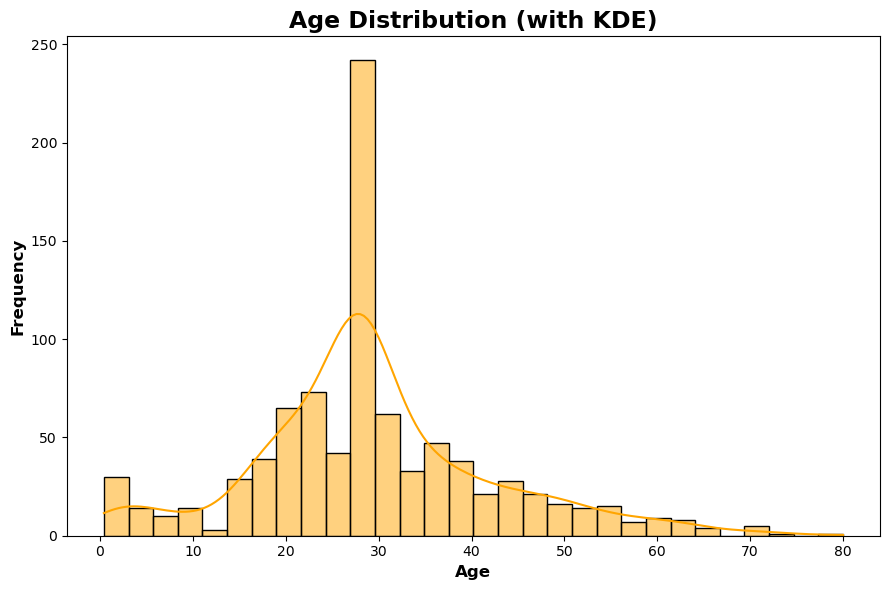

In [6]:
# Plot age distribution
plt.figure(figsize=(9,6))
sns.histplot(x=tita['age'], bins=30, kde=True, color='orange' )
plt.title("Age Distribution (with KDE)", fontsize=17, weight='bold')
plt.ylabel("Frequency", weight='bold', fontsize=12)
plt.xlabel("Age", weight='bold', fontsize=12)
plt.tight_layout()
plt.show()

#### Comment:
This chart indicates that many of the passengers were in their late 20s, making it the most important age group on board. The KDE curve helps estimate the age distribution more smoothly. The bar is way higher than the KDE peak, indicating a strong concentration in that exact age range.

<br></br>

### Donutplot

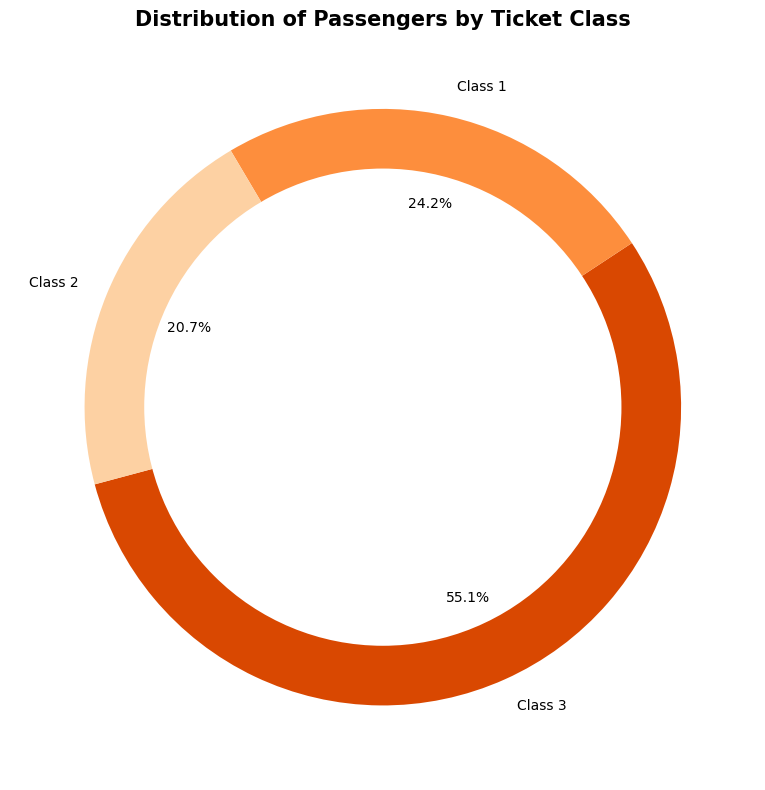

In [7]:
# Number of passenger per class
pclass_count = tita['pclass'].value_counts()

# Create labels
my_labels= [f"Class {cl}" for cl in pclass_count.index]

# Donut chart
plt.figure(figsize=(9,8))
plt.pie(pclass_count.values, labels= my_labels, autopct='%1.1f%%',startangle=195, pctdistance=0.7,
    colors=sns.color_palette('Oranges_r', len(pclass_count)))

# Add circle in the center to make donutplot
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Distribution of Passengers by Ticket Class', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

#### Comment:
Over half of the passengers traveled in Class 3, while Class 1 and Class 2 accounted for less than 50% together. This indicates that the ship carried predominantly low-income passengers, with comparatively fewer travelers in the higher-priced classes.

<br></br>

### This section analyzes fare patterns across passenger class and sex to identify potential differences in pricing among traveler groups.

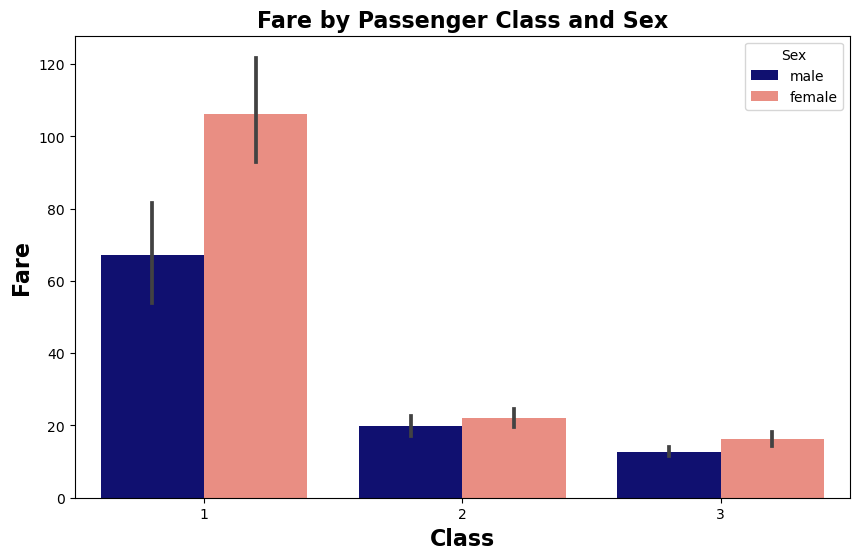


An idea of the average fare paid per class:
    pclass    mean
0       1  84.155
1       2  20.662
2       3  13.676


In [13]:
# Plot the relation between passenger class and fare by sex
plt.figure(figsize=(10, 6))
sns.barplot(data=tita, x='pclass', y='fare', hue='sex', palette={'male':'navy','female':'salmon'} )
plt.title("Fare by Passenger Class and Sex", fontsize=16, weight='bold')
plt.xlabel("Class", weight='bold', fontsize=16)
plt.ylabel("Fare", weight='bold', fontsize=16)
plt.legend(title="Sex")
plt.show()

# Grouped Stats
grouped_stats = tita.groupby('pclass')['fare'].agg(['mean'])
grouped_stats = grouped_stats.reset_index()

print('\nAn idea of the average fare paid per class:\n', round(grouped_stats,3))

#### Comment:
Fares decrease steadily from Class 1 to Class 3, and within every class, women paid more than men. It is noticeable that the gap is the largest in Class 1 (women paid nearly double), indicating greater use of higher-priced cabins. In Classes 2 and 3, the differential is narrow, which is consistent with standardized accommodations and reduced price variability.

<br></br>

### Does having more family ties affect a passenger's chance of survival?

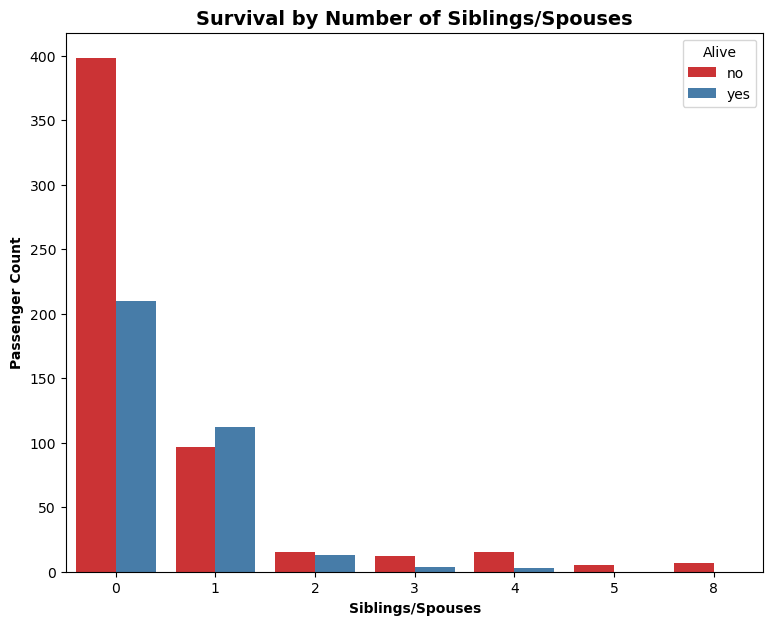

In [11]:
# Plot Survival by Number of Siblings/Spouses
plt.figure(figsize=(9,7))
sns.countplot(x="sibsp", hue="alive", data=tita, palette="Set1")
plt.title("Survival by Number of Siblings/Spouses", fontsize=14, weight="bold")
plt.xlabel("Siblings/Spouses", weight='bold')
plt.ylabel("Passenger Count", weight='bold')
plt.legend(title="Alive")
plt.show()

<br></br>

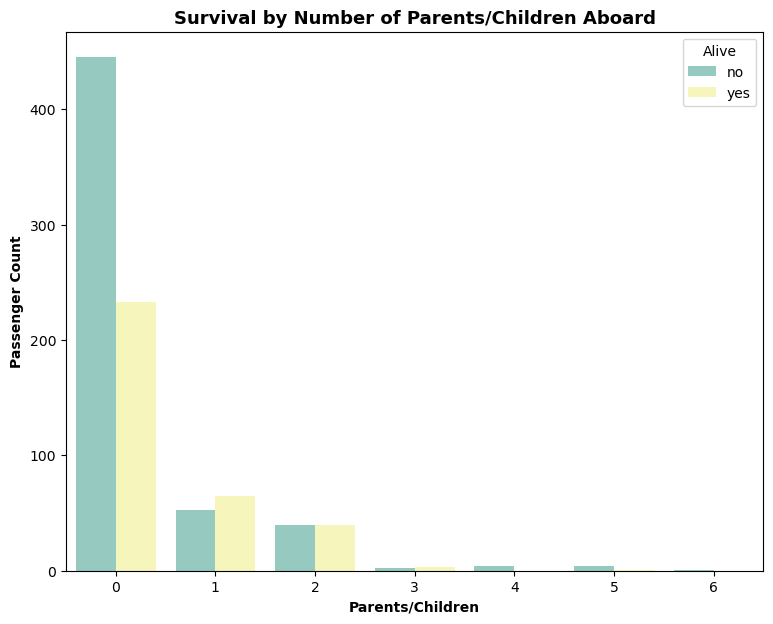

In [12]:
# Plot Survival by parents/chidren
plt.figure(figsize=(9,7))
sns.countplot(x="parch", hue="alive", data=tita, palette="Set3")
plt.title("Survival by Number of Parents/Children Aboard", fontsize=13, weight="bold")
plt.xlabel("Parents/Children",weight='bold')
plt.ylabel("Passenger Count",weight='bold')
plt.legend(title="Alive")
plt.show()

#### Comment:
Overall, the survival pattern suggests that family structure played an important role on the Titanic: **passengers who traveled with relatives often showed different survival outcomes compared to those who traveled alone**. Indeed, the presence and size of family groups may have influenced their chances of survival.

<br></br>

### How survival probability changes with family groups?

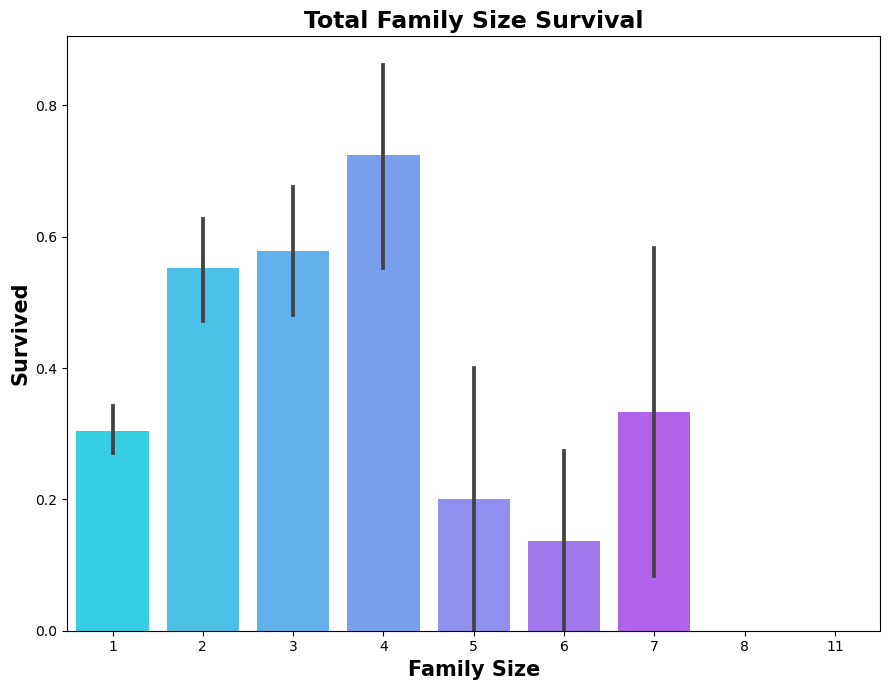

In [9]:
# Sum siblings, parents, and children
tita['family_size'] = tita['sibsp'] + tita['parch'] + 1

# barplot
plt.figure(figsize=(9,7))
sns.barplot(x='family_size', y='survived', data=tita, palette='cool')
plt.xlabel("Family Size", weight='bold', fontsize=15)
plt.ylabel("Survived", weight='bold', fontsize=15)
plt.title("Total Family Size Survival",weight='bold', fontsize=17)
plt.tight_layout()
plt.show()

#### Comment:
The relationship between family size and survival probability is irregular. Passengers with family sizes of 3 and  4 have the highest survival rates, suggesting that **moderate familiy groups benefited from greater mutual support**. Survival decreases for single travelers and for larger family groups (5-7), likely due to reduced mobility in the panic.

<br></br>

### A clear view of survival differences by embarkation port.

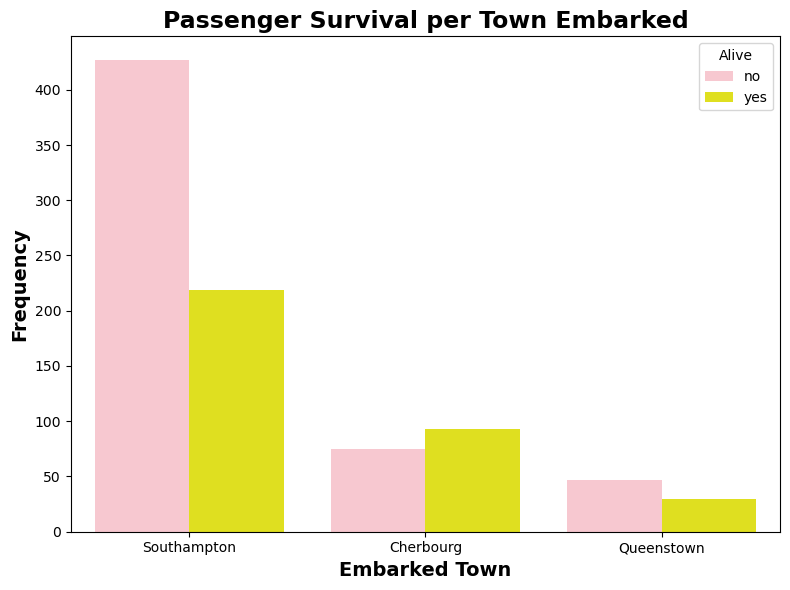

In [35]:
# Embarked survival barplot
plt.figure(figsize=(8,6))
sns.countplot(x='embark_town', hue='alive', palette=["pink","yellow"],data=tita)
plt.title("Passenger Survival by Port of Embarkation", weight='bold', fontsize= 17)
plt.xlabel("Embarked Town", weight='bold',fontsize=14)
plt.ylabel("Frequency", weight='bold', fontsize=14)
plt.legend(title="Alive")
plt.tight_layout()
plt.show()

#### Comment:
* *Southampton*, which had the largest number of passengers, shows the highest mortality, with over 400 deaths compared to roughly 200 survivors, reflecting both its large third-class population and overall passenger volume.
* *Cherbourg* displays a more balanced pattern, with around 100 survivors and fewer than 90 deaths. This is consistent with its higher share of first-class passengers.
* *Queenstown*, the smallest group of all, recorded approximately 50 deaths and 25 survivors, showing the lowest survival counts overall due to limited passenger numbers.

<br></br>

### Were there any disadvantages or advantages of traveling alone?

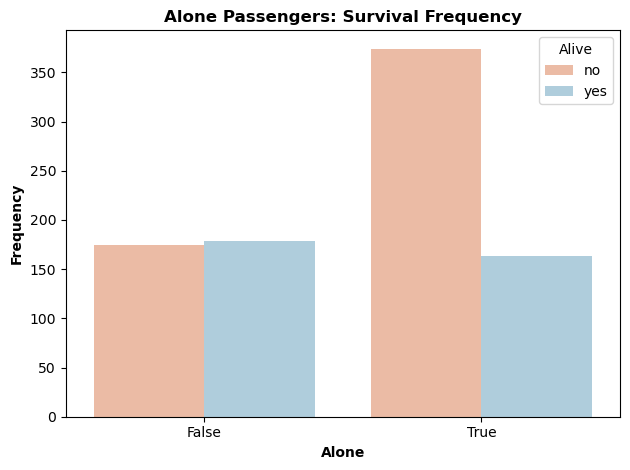

In [30]:
# Plot frequency of alone passengers
sns.countplot(x='alone', hue='alive', palette='RdBu', data=tita)
plt.xlabel("Alone", weight='bold')
plt.ylabel("Frequency", weight='bold')
plt.title("Alone Passengers: Survival Frequency", weight='bold')
plt.legend(title="Alive")
plt.tight_layout()
plt.show()

#### Comment:
When passengers were not alone, the survival rate slightly exceeded the death rate, mirroring that having a family or companions may have offered a protective effect. The pattern reverses when passengers are alone: more than half failed to survive. This shows that **social connections may have improved access to assistance and prioritization during evacuation.**

<br></br>

### Boxplots (to spot fare outliers)

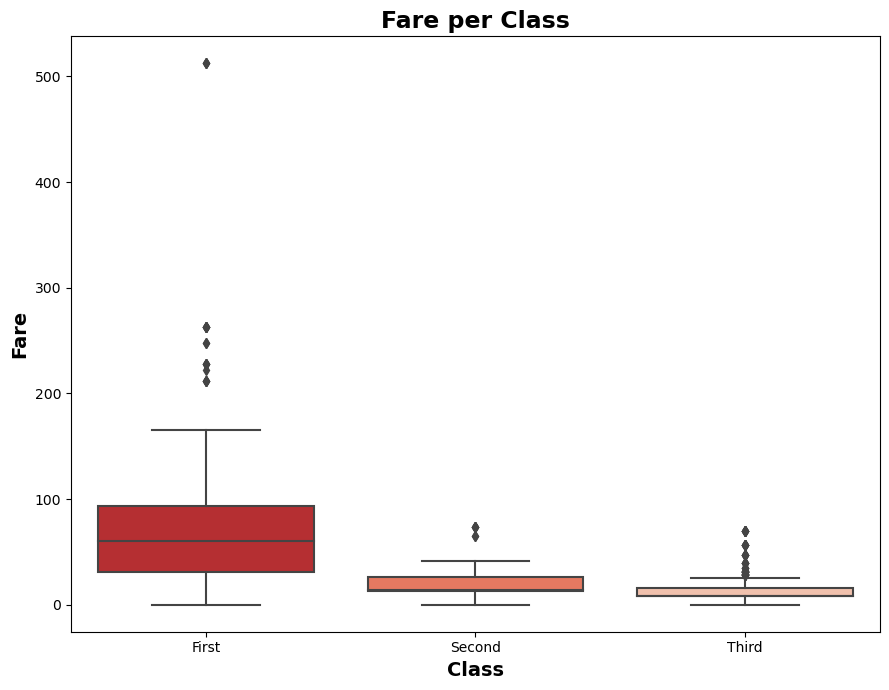

In [15]:
# Boxplot of fare per class
plt.figure(figsize=(9,7))
sns.boxplot(x='class', y='fare', palette='Reds_r', data=tita)
plt.title("Fare per Class", weight='bold', fontsize= 17)
plt.xlabel("Class", weight='bold',fontsize=14)
plt.ylabel("Fare", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()

#### Comment:
The expected patterns are shown there: **First Class passengers paid substantially more**, with the highest outlier above 500 and the highest fare median compared to the other classes.

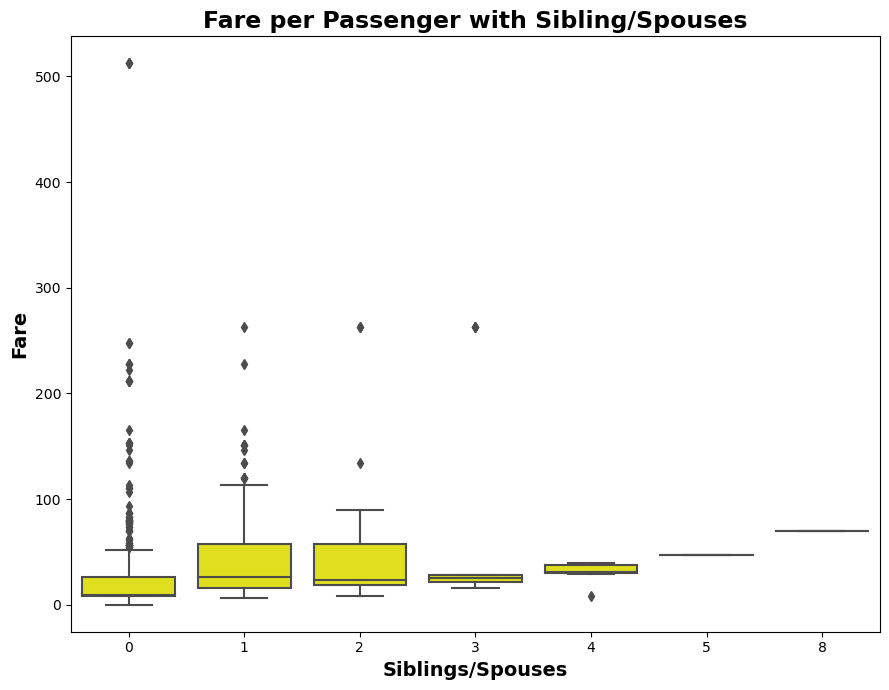

In [32]:
# Fare per Passenger with Sibling/Spouses
plt.figure(figsize=(9,7))
sns.boxplot(x='sibsp', y='fare', color='yellow', data=tita)
plt.title("Fare per Passenger with Sibling/Spouses", weight='bold', fontsize= 17)
plt.xlabel("Siblings/Spouses", weight='bold',fontsize=14)
plt.ylabel("Fare", weight='bold', fontsize=14)
plt.tight_layout()
plt.show()

#### Comment:
When examining this distribution, passengers traveling alone exhibit the most extreme outlier (a fare above 500) as well as the largest spread. Those with one sibling/spouse show the second-highest outlier frequency, while the median fare increases slightly as the number of companions grows. Overall, fare shows meaningful variability depending on whether passengers traveled alone or with family.

<br></br>

## Hypothesis Testing

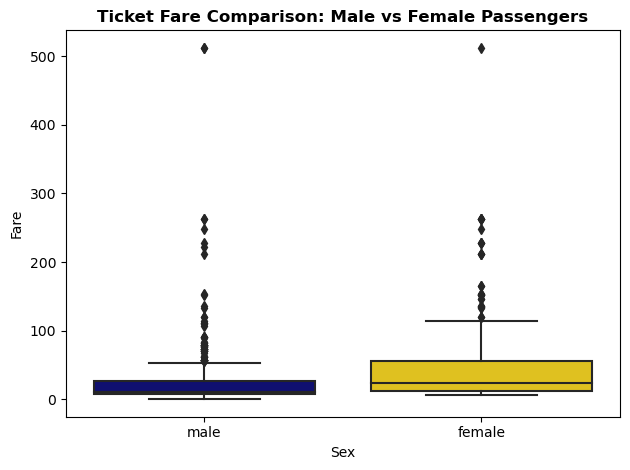

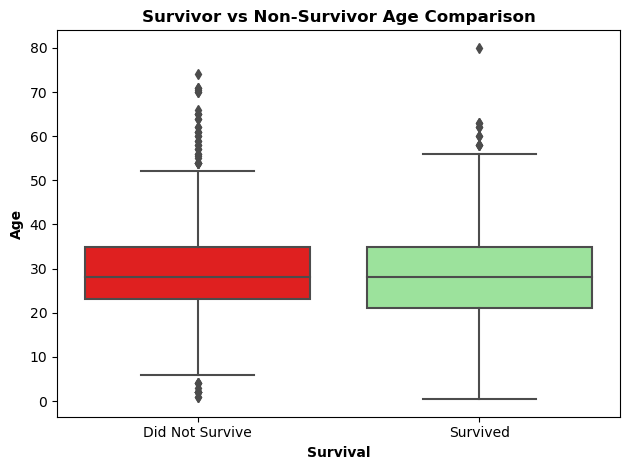

In [17]:
# Plot boxplot 1
sns.boxplot(x='sex', y='fare', data=tita, palette={'male':'navy', 'female':'gold'})
plt.title('Ticket Fare Comparison: Male vs Female Passengers', weight='bold')
plt.xlabel('Sex')
plt.ylabel('Fare')
plt.tight_layout()
plt.show()

# Plot boxplot 2
sns.boxplot(x='survived', y='age', data=tita, palette=['red','lightgreen'])
plt.xticks([0, 1], ['Did Not Survive', 'Survived'])
plt.title('Survivor vs Non-Survivor Age Comparison', weight='bold')
plt.xlabel('Survival', weight='bold')
plt.ylabel('Age',weight='bold')
plt.tight_layout()
plt.show()

In [18]:
# Subset on male and female passengers
male_fare =tita[tita['sex'] == 'male']['fare'] 
female_fare = tita[tita['sex'] == 'female']['fare'] 

# Subset survivors and non-survivors
survivors = tita[tita['survived'] == 1]['age']
non_survivors = tita[tita['survived'] == 0]['age']

# Perform t-test to compare values of fare for both sexes 
t_test_results = ttest_ind(male_fare, female_fare)
print(f'Fare Difference by Gender Results: statistic = {t_test_results[0]:.4f}, P-value = {t_test_results[1]:.4f}')
print()

# Perform t-test to compare survival passengers age
t_test_results2 = ttest_ind(survivors, non_survivors)
print(f'Survival Age Difference Results: statistic = {t_test_results2[0]:.4f}, P-value = {t_test_results2[1]:.4f})')

Fare Difference by Gender Results: statistic = -5.5291, P-value = 0.0000

Survival Age Difference Results: statistic = -1.9395, P-value = 0.0528)


<br></br>

#### Fare Difference by Gender Results:
* The t-test result *(statistic = -5.5291, p-value = 0.0000)* shows a highly significant difference in fares paid by men and women.
* This suggests that women generally paid higher fares, likely reflecting access to higher-class cabins and greater survival odds.

#### Survival Age Difference Results:

* The t-test result *(statistic = -1.9395, p-value = 0.0528)* indicates no evidence of a significant difference in age between survivors and non-survivors in the Titanic.


<br></br>

### How balanced are the surviving classes?

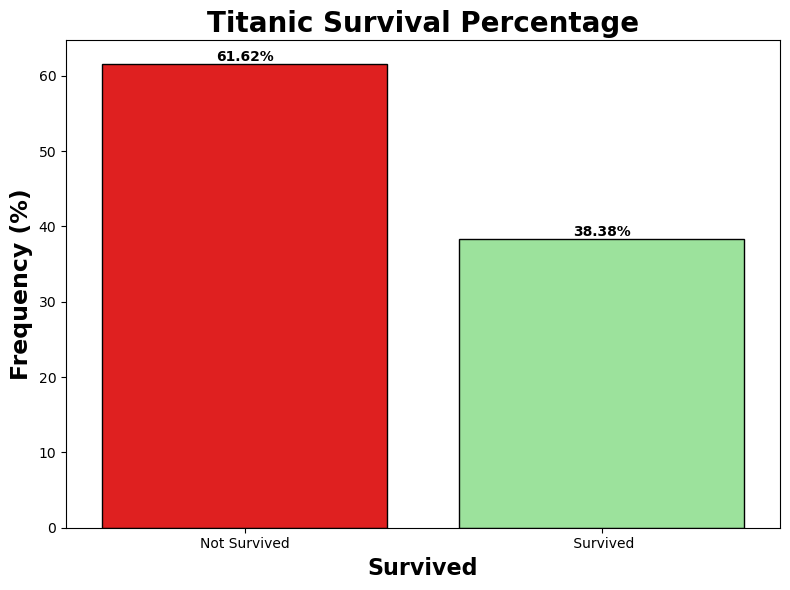

In [41]:
# count survivors
survival_counts = tita['survived'].value_counts(normalize=True) * 100

# Plot Survival counts
plt.figure(figsize=(8,6))
ax = sns.barplot(x=survival_counts.index, y=survival_counts.values, 
            palette= ['red', 'lightgreen'], edgecolor='black')
# Annotate barplots
for i, val in enumerate(survival_counts.values):
    ax.text(i, val, f"{val:.2f}%" ,ha='center', va='bottom', weight='bold',fontsize=13)
plt.title('Titanic Survival in %', weight='bold',fontsize=17)
plt.xlabel('Survived', fontsize= 16, weight='bold')
plt.xticks([0,1], ['Not Survived',' Survived'])
plt.ylabel('Frequency (%)', fontsize=17, weight='bold')
plt.tight_layout()
plt.show()

<blockquote style="border-left: 8px solid red; padding: 10px; background-color: #f9f9f9;" ;> About 38% of the passengers in the data set survived. Because of this slight imbalance, we should stratify the data when performing train/test split and for cross-validation.</blockquote> 

---

# Modeling

<br></br>

### Logistic Regression

In [20]:
# Select relevant features and target
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

# One-hot encode categorical variables
tita_encoded = pd.get_dummies(tita[features], drop_first=True)

# Define X and y
X = tita_encoded
y = tita[target]

In [21]:
# Check which test split generalizes best accuracy

for size in [0.1, 0.2, 0.3]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42, stratify=y)
    log_regs = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced',random_state=42)
    log_regs.fit(X_train, y_train)
    y_pred = log_regs.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size of {size:.1f} Gives Accuracy of: {acc:.2f}")

Test size of 0.1 Gives Accuracy of: 0.82
Test size of 0.2 Gives Accuracy of: 0.84
Test size of 0.3 Gives Accuracy of: 0.82


In [22]:
# Split with 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit Logistic Regression
logreg = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



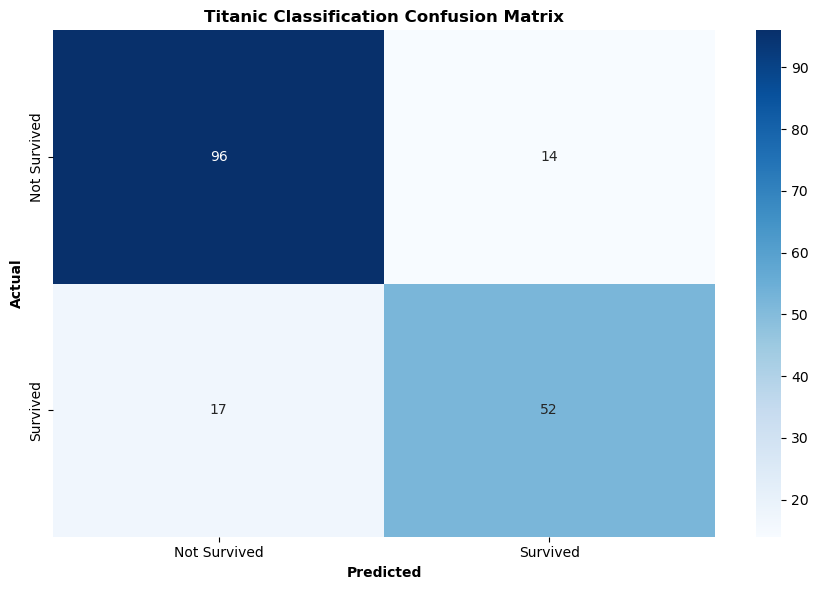

In [40]:
# Display the confusion matrix for the new model 
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Titanic Classification Confusion Matrix', weight='bold')
plt.xlabel('Predicted', weight='bold')
plt.ylabel('Actual', weight='bold')
plt.tight_layout()
plt.show()


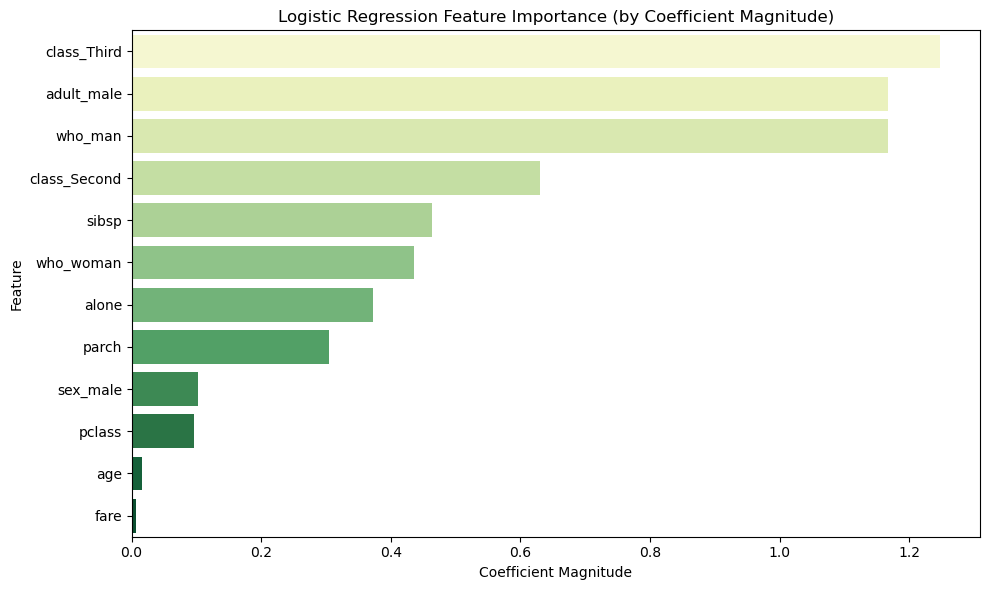

In [24]:
# Get feature names from encoded data
feature_names = X_train.columns

# Get coefficients from trained model
coefficients = logreg.coef_[0]  

# Create DataFrame
feat_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by absolute value of coefficients
feat_df['Abs_Coefficient'] = feat_df['Coefficient'].abs()
feat_df = feat_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feat_df, palette='YlGn')
plt.title("Logistic Regression Feature Importance (by Coefficient Magnitude)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Interpretation:
The Logistic Regression model emphasizes third-class status and adult male as the strongest predictors of non-survival, indirectly supporting the idea that women and children, especially from higher classes, were more likely to survive.

<br></br>

### Random Forest

In [25]:
# Check which test split generalizes best accuracy
for size in [0.1, 0.2, 0.3]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42, stratify=y)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size of {size:.1f} Gives Accuracy of: {acc:.2f}")

Test size of 0.1 Gives Accuracy of: 0.80
Test size of 0.2 Gives Accuracy of: 0.83
Test size of 0.3 Gives Accuracy of: 0.82


In [26]:
# Split dataset with test size of 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
           1       0.79      0.75      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



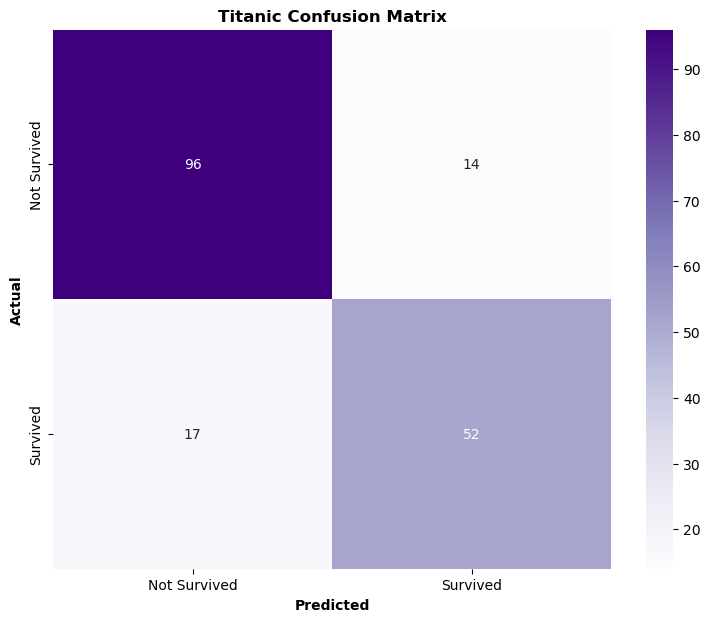

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion matrix
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted', weight='bold')
plt.ylabel('Actual',weight='bold')
plt.title('Titanic Confusion Matrix',weight='bold')
plt.tight_layout()
plt.show()

### Interpretation:

*   True Negatives (96): The model correctly predicted that 96 passengers did not survive.
*   False Positives (14): The model incorrectly predicted survival for 14 passengers who actually died.
*   False Negatives (17): The model missed 17 survivors, predicting they didn't survive.
*   True Positives (52): The model correctly identified 52 survivors.





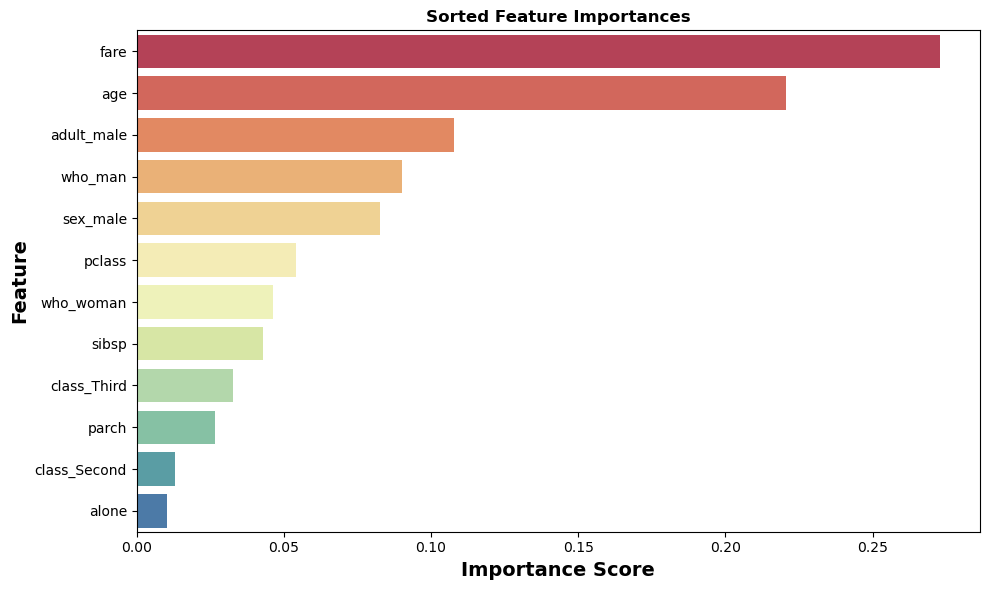

In [28]:
# Feature importance
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for sorting features
feat_df = pd.DataFrame({'Feature': feature_names,'Importance': importances})

# Sort by importance descending
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot Feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette= 'Spectral')
plt.title("Sorted Feature Importances", weight='bold')
plt.xlabel("Importance Score",fontsize=14,weight='bold',)
plt.ylabel("Feature", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

### Interpretation:
The feature importance chart reveals which variables most strongly influenced the model's survival predictions.
1. `Fare` and `Age` are the top contributors. Fare is a strong proxy for passenger class because higher fares were more likely to be paid by First Class passengers. Younger passengers had higher survival chances, while older adults had lower chances.

2. `Adult_male`, `who_man`, and `sex_male` rank highly, reinforcing the model's sensitivity to gender, which aligns with the 'women and children first' evacuation protocol. Thus, being a male adult lowered survival probability.

3. Features like `Alone` and `Class_Second` had relatively low importance, indicating they contributed less to the model's decision-making.

<br></br>

<blockquote style="border-left: 2px solid red; border-right:2px solid red; border-top:2px solid red; border-bottom:2px solid red;
    padding: 10px; background-color: #f9f9f9; font-weight: bold;"> This indicates that social class and economic privilege were the dominant factors in survival. </blockquote>


---

<br></br>

# Final Thoughts

<div style="text-align:justify; font-size:18px;">Taken together, these models reinforce the historical truth that survival on the Titanic was shaped by a mix of gender, age, and socioeconomic status, with Random Forest offering a more nuanced reflection of how money and privilege influenced access to lifeboats. When predicting survivors, the most important measure is recall, as it shows how many of the actual survivors the model correctly identifies. 
In historical analysis, this matters more than avoiding a few false positives, because the goal is to capture as complete a picture as possible of who survived. While precision tells us how many predicted survivors truly survived, it’s less critical here since misclassifying a few non‑survivors has little consequence. By prioritizing recall, we ensure that the analysis includes as many true survivors as possible, even if the model makes a few mistakes, ultimately giving us a richer understanding of the human factors that shaped survival during the disaster.
</div>

<div style="text-align:justify; font-size:18px;">While Random Forest captures complex, nonlinear relationships like fare's proxy for class, Logistic Regression offers a clearer narrative: <b>being male and in third class significantly reduced survival chances</b>. In cinematic terms, Jack Dawson from James Cameron's Titanic embodies this statistical reality: a young, lower-class male whose fate reflects the demographic with the lowest probability of survival. Strangely, his character serves as a human illustration of the data, reminding us that behind the numbers were real individuals whose gender, age, and socioeconomic position determined their access to lifeboats and, ultimately, their chance of survival.
</div>

<br></br>

<div style="text-align:left; font-size:17px;"> Presented by:  <a href="https://www.linkedin.com/in/carllegros/" target="_blank" style="color:#0077b6; text-decoration:none;"> Carl Legros</a>
</div>
